In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import pyrtools as pt
import plenoptic as po
import scipy.io as sio
import os.path as op


torch.__version__
numpy = lambda x: x.detach().cpu().numpy().squeeze()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
image = plt.imread('../data/nuts.pgm').astype(float)/255.
im0 = torch.tensor(image, requires_grad=True, dtype = torch.float32).squeeze().unsqueeze(0).unsqueeze(0)
pyr = po.simul.Steerable_Pyramid_Freq((256,256), height=3, order=1, is_complex=True)
pp=pyr.forward(im0)
print([val.shape for val in pp.values()])

[torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256, 2]), torch.Size([1, 1, 256, 256, 2]), torch.Size([1, 1, 128, 128, 2]), torch.Size([1, 1, 128, 128, 2]), torch.Size([1, 1, 64, 64, 2]), torch.Size([1, 1, 64, 64, 2]), torch.Size([1, 1, 32, 32])]


In [3]:
import time
model = po.simul.Portilla_Simoncelli([256,256],n_scales=4, n_orientations=4, Na=5)
image = plt.imread('../data/nuts.pgm').astype(float)
im0 = torch.tensor(image, requires_grad=True, dtype = torch.float32).squeeze().unsqueeze(0).unsqueeze(0)

start = time.time()
y = model.forward(im0)
end = time.time()
print(end - start)

0.16428804397583008


In [4]:
import glob
directory = '/Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/'
jpg = glob.glob(f'{directory}*.jpg')

In [29]:
coeffs = np.ones([2456,len(jpg)])
model = po.simul.Portilla_Simoncelli([256,256],n_scales=4, n_orientations=4, Na=9)
cnt = 0
for ind,file in enumerate(jpg):
    print(f'{ind}: {file}')
    image = plt.imread(file).astype(float).mean(axis=2)/255.
    if image.shape[0]==512 and image.shape[1] == 512:
        im0 = torch.tensor(image[:256,:256], requires_grad=True, dtype = torch.float32).squeeze().unsqueeze(0).unsqueeze(0)
        coeffs[:,cnt] = model.forward(im0).detach().numpy()
        
        cnt+=1
coeffs = coeffs[:,:cnt]

0: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_9915.jpg
1: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_1385.jpg
2: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_9929.jpg
3: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_1420.jpg
4: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/d30_8249.jpg
5: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/d30_8261.jpg
6: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/DSCF8527.jpg
7: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/DSCF1503.jpg
8: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/5DmkII_3985.jpg
9: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/5DmkII_3991.jpg
10: /Users/kathrynbonnen/Dropbox/N

84: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/X100_0603.jpg
85: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_3143.jpg
86: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/DSCF1449.jpg
87: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_9222.jpg
88: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_6887.jpg
89: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_8672.jpg
90: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/DSCF1461.jpg
91: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_8666.jpg
92: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/5DmkII_3978.jpg
93: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/img_2359.jpg
94: /Users/kathrynbonnen/D

168: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_7981a.jpg
169: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/d30_8264.jpg
170: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_1343.jpg
171: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/DSCF1506.jpg
172: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/5DmkII_3980.jpg
173: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_8073.jpg
174: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/5DmkII_3994.jpg
175: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/d30_3899.jpg
176: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_0263.jpg
177: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/X100_0764.jpg
178: /Users/

252: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/g1_2434.jpg
253: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_1708.jpg
254: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_0402.jpg
255: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_3645.jpg
256: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/IMG_6771.jpg
257: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_2984_2.jpg
258: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_7898a.jpg
259: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_8014.jpg
260: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_1318.jpg
261: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_7858.jpg
262: /Users/kathry

336: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_7057.jpg
337: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/d30_8629.jpg
338: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_8833.jpg
339: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_2982_2.jpg
340: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_3119.jpg
341: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_8827.jpg
342: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_7952a.jpg
343: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_8600.jpg
344: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/d30_2264.jpg
345: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_9481.jpg
346: /Users/kathr

420: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_7925.jpg
421: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/X100_0332.jpg
422: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/5DmkII_9838.jpg
423: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_8419.jpg
424: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_7064.jpg
425: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/sd1000_5472.jpg
426: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/DSCF3592.jpg
427: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_3102.jpg
428: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_3664.jpg
429: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_3116.jpg
430: /Users/k

504: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_9502.jpg
505: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_9516.jpg
506: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_3105.jpg
507: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_9700.jpg
508: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/B290C55267D745DA.jpg
509: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/oly13.jpg
510: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_8422.jpg
511: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/d30_3210.jpg
512: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_7936.jpg
513: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/d30_7710.jpg
514: /Users/kat

587: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/5DmkII_3874.jpg
588: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/X100_0860.jpg
589: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_9514.jpg
590: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/IMG_5472.jpg
591: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_3098.jpg
592: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_6753.jpg
593: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_7868.jpg
594: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_1328.jpg
595: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_7966a.jpg
596: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/d30_2087.jpg
597: /Users/kat

671: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_7987.jpg
672: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_1576.jpg
673: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/X100_0435.jpg
674: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/F8436786531D48EE.jpg
675: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_7978.jpg
676: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_2994_2.jpg
677: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_7950.jpg
678: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_0640.jpg
679: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_7944.jpg
680: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_7945.jpg
681: /Use

755: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_1406.jpg
756: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_3239.jpg
757: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/X100_1115.jpg
758: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/10D_7960a.jpg
759: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/DSCF4107.jpg
760: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/30D_1389.jpg
761: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/d30_7189.jpg
762: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/d30_8245.jpg
763: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/g1_0661.jpg
764: /Users/kathrynbonnen/Dropbox/NYU/Texture2018/imageLibraries/cropped512-gray-jpg/d30_8251.jpg
765: /Users/kathryn

In [6]:
np.save('coeff_library',coeffs)

NameError: name 'coeffs' is not defined

In [5]:

coeffs = np.load('coeff_library.npy')
coeffs_mean = torch.from_numpy(coeffs.mean(axis=1))
coeffs_std = torch.from_numpy(coeffs.std(axis=1))
coeffs_std[coeffs_std<1e-3]=1

In [12]:
image = plt.imread('../data/nuts.pgm').astype(float)/255.
im0 = torch.tensor(image[:256,:256], requires_grad=True, dtype = torch.float32).squeeze().unsqueeze(0).unsqueeze(0)    

# image = plt.imread(directory+'6DBB09D9E2E04BFF.jpg').astype(float).mean(axis=2)/255.
# im0 = torch.tensor(image[:256,:256], requires_grad=True, dtype = torch.float32).squeeze().unsqueeze(0).unsqueeze(0)    
model = po.simul.Portilla_Simoncelli([256,256],n_scales=4, n_orientations=4, Na=9,
                                     normalize=True, normalization_mu=coeffs_mean, normalization_std=coeffs_std)
met = po.synth.Metamer(im0, model)
m=met.synthesize(learning_rate=.5,loss_thresh=20,loss_change_thresh=100,max_iter=400,coarse_to_fine='together')



 91%|█████████ | 364/400 [04:53<00:29,  1.24it/s, current_scale=all, current_scale_loss=2.42, gradient_norm=1.1526e-01, learning_rate=0.0625, loss=2.4240e+00]           


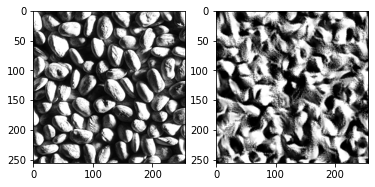

In [13]:
fig=plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(image[:256,:256],cmap='gray',vmin=0,vmax=1)

fig.add_subplot(1,2,2)
plt.imshow(m[0].squeeze().detach().numpy(),cmap='gray',vmin=0,vmax=1)

In [5]:
[s for s in [0,1,2,3] for i in range(0,3)]

[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]